# Machine Learning Modelling

In this notebook we will develop and fit machine learning models on the heart failure dataset. We will utilize the insights gained from both EDA as well as survival analysis as a means of selecting the features that the model will train upon.

EDA showed that this is an imbalanced problem where 2/3 of the dataset have not died following heart failure, thus, it will be important to use metrics that accurately reflect the performance of the model.

We will use the following models:
- Logistic Regression, this is a simple model which can serve as a baseline as well as a means of understanding whether the selected features are predictive of the outcome.
- Decision Tree, this is a slightly more complex model which can capture non-linear relationships between the features and the outcome.
- Random Forest, this is a more complex model which can capture non-linear relationships between the features and the outcome.

Based on the performance of the models, we will possible consider the use of a stacking ensemble model.

Lastly, we will track the experiments using MLFlow.

## Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import time
import mlflow

## Data Loading

In [3]:
heart_data = pd.read_csv('heart_data_processed.csv')

In [5]:
selected_features = ['age', 'ejection_fraction', 'bp', 'serum_creatinine']
X = heart_data[selected_features]
y = heart_data['death']

In [6]:
X.head()

,age,ejection_fraction,bp,serum_creatinine
0,75.0,20,1,1.9
1,55.0,38,0,1.1
2,65.0,20,0,1.3
3,50.0,20,0,1.9
4,65.0,20,0,2.7


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [9]:
continuous_features = ['age', 'ejection_fraction','serum_creatinine']
scaler = RobustScaler()
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

## Setting ML Flow

In [10]:
mlflow.create_experiment('Heart Failure Death Prediction')

'287474788380947887'

In [12]:
mlflow.set_experiment('Heart Failure Death Prediction')

<Experiment: artifact_location='file:///Users/akhtar/Documents/Documents-Suhaib/Data%20Science%20Projects/heart_failure_analysis/mlruns/287474788380947887', creation_time=1700660900320, experiment_id='287474788380947887', last_update_time=1700660900320, lifecycle_stage='active', name='Heart Failure Death Prediction', tags={}>

## Model Training

We will begin by training the logistic regression model. To so do we will utilize grid search on the following hyperparameters:
- C, the inverse of the regularization strength
- penalty, the regularization type
- max_iter, the maximum number of iterations
- class_weight, balanced of None

In [32]:
hp_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 500, 1000],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None]
}

In [34]:
lr_model = LogisticRegression(random_state=42, solver='liblinear')
grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=hp_grid,
    cv=3,
    n_jobs=-1,
    refit=True
)

with mlflow.start_run(run_name='Logistic Regression - All HParams - liblinear'):
    start = time.time()
    grid_search.fit(X_train, y_train)
    end = time.time()
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    best_params = grid_search.best_params_

    mlflow.log_param('best_params', best_params)
    mlflow.log_metric('accuracy', best_model.score(X_test, y_test))
    mlflow.sklearn.log_model(best_model, 'lr_model')
    mlflow.log_metric('precision', precision_score(y_test, y_pred, average='weighted'))
    mlflow.log_metric('recall', recall_score(y_test, y_pred, average='weighted'))
    mlflow.log_metric('f1_score', f1_score(y_test, y_pred, average='weighted'))
    mlflow.log_metric('training_time', end-start)


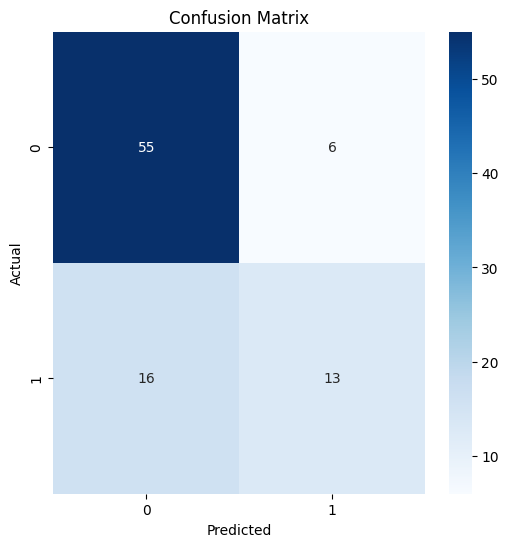

In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()